# Inspect Pi Data and Raw VCFs in R

In [2]:
library(data.table)
library(dplyr)
library(tidyr)
library(ggplot2)

options(jupyter.plot_mimetypes = 'image/png') ## to avoid bloated size

Read a Single File

use data.table fread cos its fast and scales

In [2]:
PiDT <- fread('gzip -dc ./CK_13_CHR1.Pi.gz')
head(PiDT)

CHROM,BIN_START,BIN_END,N_VARIANTS,PI
CHR1,1,10000,156,0.00479077
CHR1,10001,20000,253,0.00844585
CHR1,20001,30000,413,0.01364710
CHR1,30001,40000,164,0.00487877
CHR1,40001,50000,279,0.00892246
CHR1,50001,60000,158,0.00525415


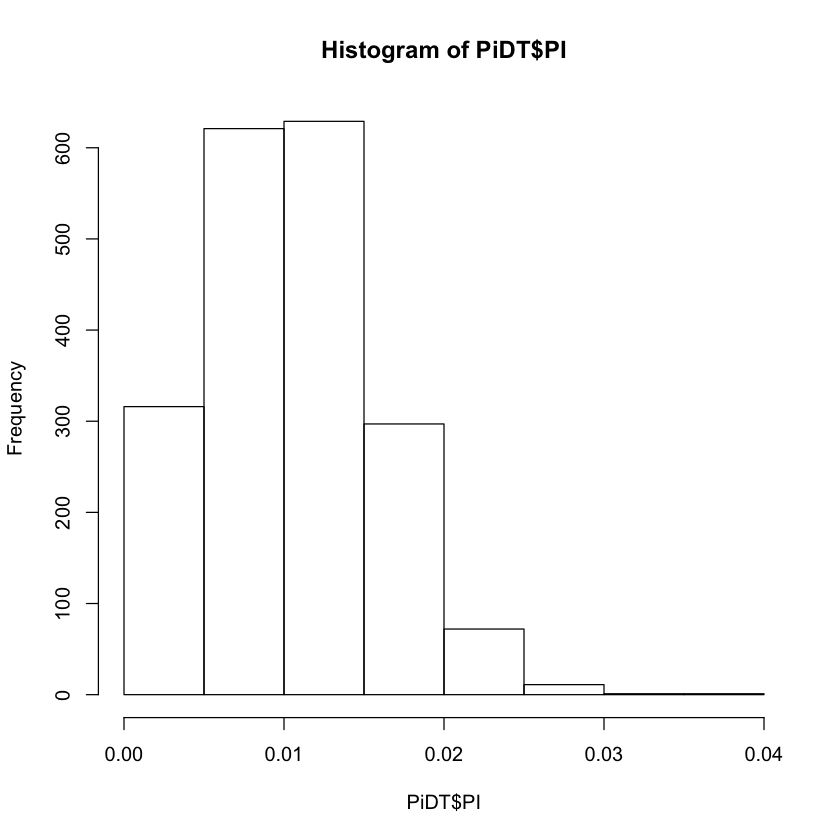

In [3]:
hist(PiDT$PI)

### Read out A Bunch of Compressed Files and Put in One Big Table

In [4]:
pi_list <- list.files('./PI',full.names = TRUE)
pi_list

[1] "./PI/CHR1.Pi.gz"  "./PI/CHR10.Pi.gz" "./PI/CHR11.Pi.gz" "./PI/CHR12.Pi.gz"
 [5] "./PI/CHR13.Pi.gz" "./PI/CHR14.Pi.gz" "./PI/CHR15.Pi.gz" "./PI/CHR16.Pi.gz"
 [9] "./PI/CHR17.Pi.gz" "./PI/CHR18.Pi.gz" "./PI/CHR19.Pi.gz" "./PI/CHR2.Pi.gz" 
[13] "./PI/CHR20.Pi.gz" "./PI/CHR21.Pi.gz" "./PI/CHR22.Pi.gz" "./PI/CHR23.Pi.gz"
[17] "./PI/CHR24.Pi.gz" "./PI/CHR25.Pi.gz" "./PI/CHR26.Pi.gz" "./PI/CHR27.Pi.gz"
[21] "./PI/CHR28.Pi.gz" "./PI/CHR29.Pi.gz" "./PI/CHR3.Pi.gz"  "./PI/CHR4.Pi.gz" 
[25] "./PI/CHR5.Pi.gz"  "./PI/CHR6.Pi.gz"  "./PI/CHR7.Pi.gz"  "./PI/CHR8.Pi.gz" 
[29] "./PI/CHR9.Pi.gz"

In [5]:
DT <- rbindlist(lapply(pi_list,function (X) fread(paste0('gzip -dc ',X))))

In [6]:
head(DT)

CHROM,BIN_START,BIN_END,N_VARIANTS,PI
CHR1,1,10000,156,0.00479077
CHR1,10001,20000,253,0.00844585
CHR1,20001,30000,413,0.01364710
CHR1,30001,40000,164,0.00487877
CHR1,40001,50000,279,0.00892246
CHR1,50001,60000,158,0.00525415


# Summarise the data.table Way

In [7]:
DT[,.(medPI=median(PI)),by=CHROM][order(medPI)] %>% head

CHROM,medPI
CHR16,0.008249075
CHR25,0.008870460
CHR27,0.008887075
CHR26,0.009096920
CHR19,0.009106150
CHR7,0.009202460


# Summarise the dplyr Way

In [8]:
DT %>%
    group_by(CHROM) %>%
    summarise(medPI=median(PI)) %>%
    arrange(medPI) %>%
    head()

CHROM,medPI
CHR16,0.008249075
CHR25,0.008870460
CHR27,0.008887075
CHR26,0.009096920
CHR19,0.009106150
CHR7,0.009202460


## Plot by Chromosome Using GGplot2

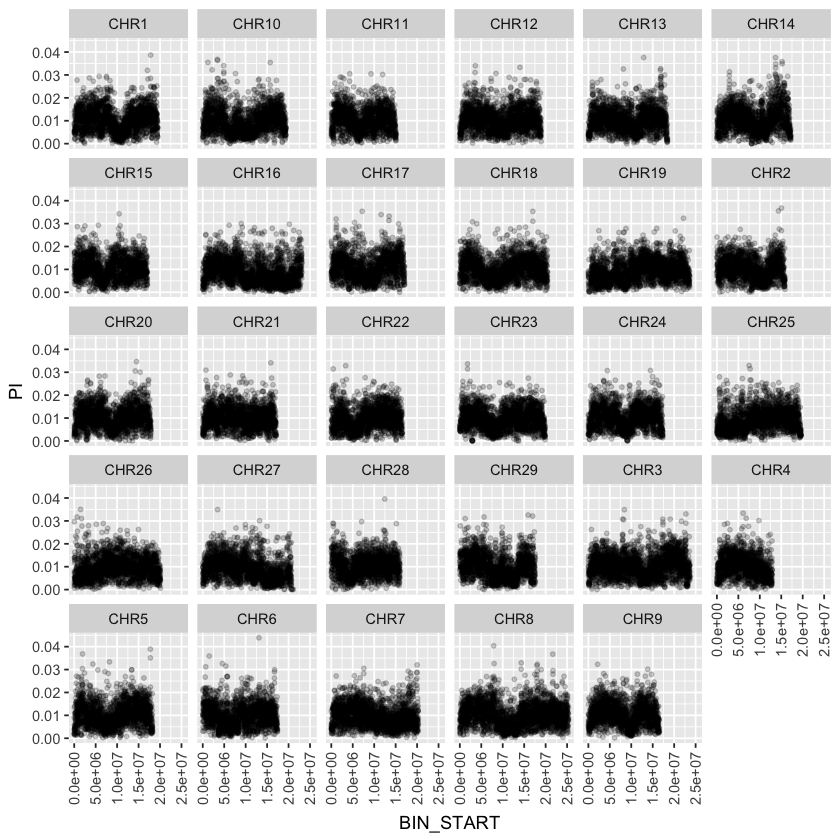

In [9]:
DT %>% ggplot(aes(x=BIN_START,y=PI)) + 
    geom_point(size=1,alpha=0.2) + 
    facet_wrap(~ CHROM) +
    theme(axis.text.x  = element_text(angle=90, vjust=0.5))

# Just Plot One Chromosome

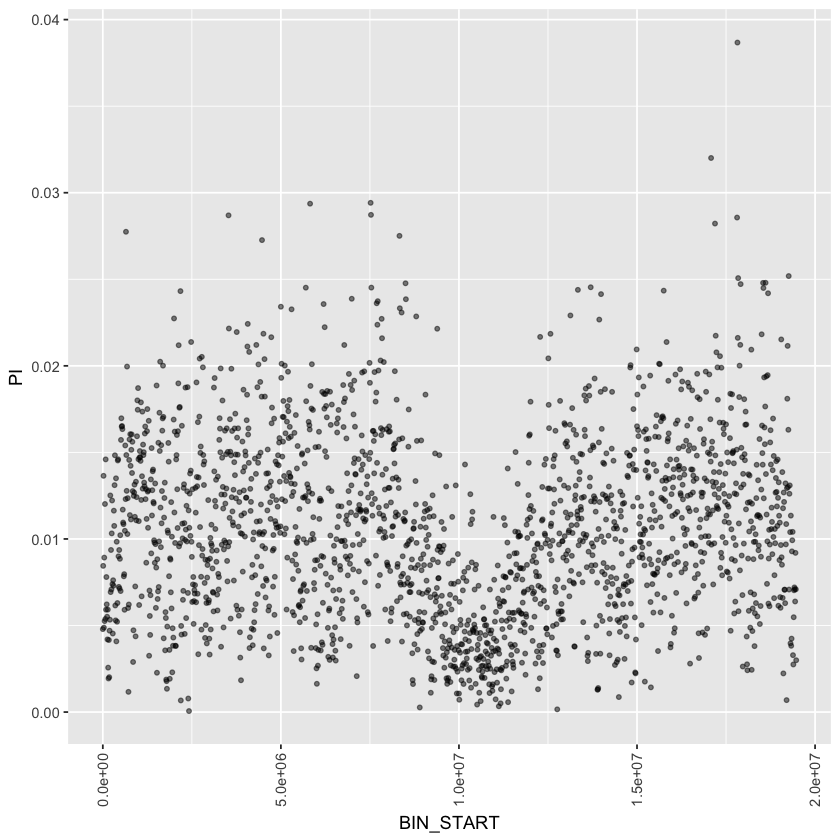

In [10]:
DT %>% 
    filter(CHROM=='CHR1') %>%
    ggplot(aes(x=BIN_START,y=PI)) + 
    geom_point(size=1,alpha=0.5) + 
    theme(axis.text.x  = element_text(angle=90, vjust=0.5))

# HOWTO-Process Directly into Data.tables
## Filter out Biallelic SNPs 

- pipe through vcflib commands to slim down the data
- just keep the MAF Field
- just keep the depth DP per sample
- and Read into a Data.Table

In [11]:
DT2 <- fread('vcffilter -f "NUMALT = 1" CHR1_200kb_PS1_1.68.5_bwaMEM_Freebayes.vcf.gz | vcfkeepinfo - AF | vcfkeepgeno - DP')

In [12]:
DT2$INFO <- as.numeric(gsub("AF=","",DT2$INFO))
DT2 %>% head

#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,CK15_02,⋯,CK51_09,CK51_11,Hort16A,Hort22d,Russell,T03.51-11-28f,T94.30-03-10f,T94.30-04-08b,T94.30-04-08c,T94.30-04-08d
CHR1,361,.,GGTAAGGCTAACCACAGGTACATCCAAGCTTCTC,GC,223.367,.,0.1153850,DP,34,⋯,38,28,34,48,39,29,23,30,41,39
CHR1,436,.,A,C,5853.080,.,0.3461540,DP,37,⋯,65,62,48,59,48,42,42,43,56,53
CHR1,499,.,CGC,CGGC,401.709,.,0.0384615,DP,39,⋯,83,67,46,62,47,44,50,61,62,53
CHR1,535,.,C,T,7254.800,.,0.3461540,DP,36,⋯,91,73,58,54,56,37,59,72,61,57
CHR1,542,.,C,T,409.493,.,0.0384615,DP,37,⋯,93,72,56,55,51,33,56,69,65,55
CHR1,558,.,T,G,772.168,.,0.0384615,DP,34,⋯,95,68,63,50,54,34,59,77,66,67


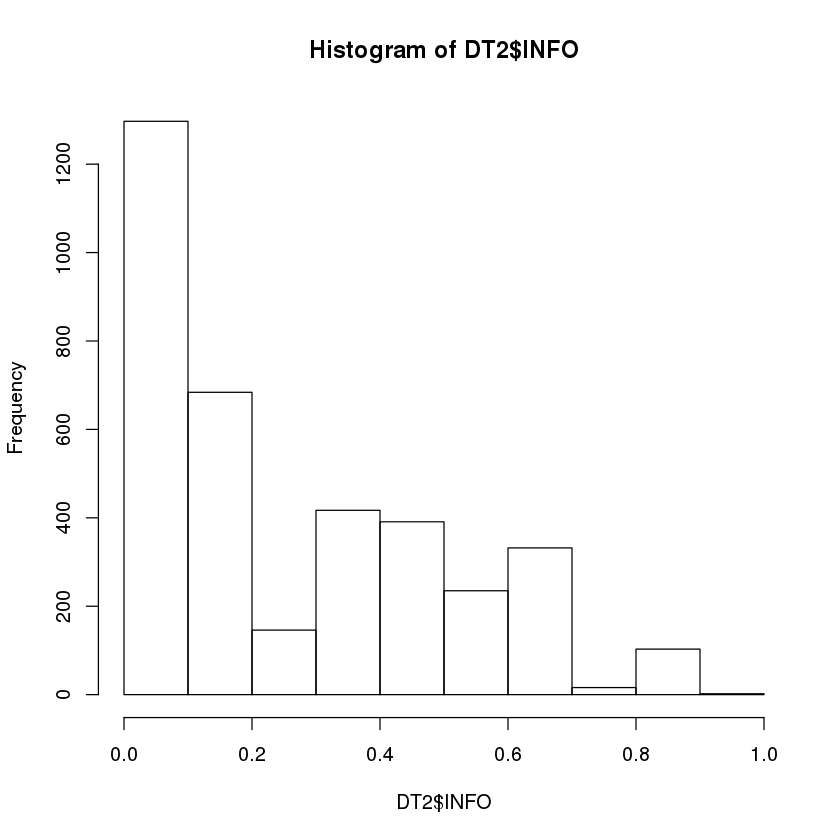

In [20]:
hist(DT2$INFO)

## Use Tidy Ops: select and Gather (Melt)

In [21]:
DT2 %>%
    select(-3:-9) %>%
    head

,#CHROM,POS,CK15_02,CK51_05,CK51_06,CK51_09,CK51_11,Hort16A,Hort22d,Russell,T03.51-11-28f,T94.30-03-10f,T94.30-04-08b,T94.30-04-08c,T94.30-04-08d
1,CHR1,361,34,40,50,38,28,34,48,39,29,23,30,41,39
2,CHR1,436,37,49,75,65,62,48,59,48,42,42,43,56,53
3,CHR1,499,39,39,68,83,67,46,62,47,44,50,61,62,53
4,CHR1,535,36,38,69,91,73,58,54,56,37,59,72,61,57
5,CHR1,542,37,40,70,93,72,56,55,51,33,56,69,65,55
6,CHR1,558,34,44,74,95,68,63,50,54,34,59,77,66,67


In [22]:
DT2 %>%
    select(-3:-9) %>%
    gather(Vine,Depth,-1:-2) %>%
    head

,#CHROM,POS,Vine,Depth
1,CHR1,361,CK15_02,34
2,CHR1,436,CK15_02,37
3,CHR1,499,CK15_02,39
4,CHR1,535,CK15_02,36
5,CHR1,542,CK15_02,37
6,CHR1,558,CK15_02,34


## Plot the Melted Data

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
: Removed 56 rows containing non-finite values (stat_bin).Warning message:
: Removed 13 rows containing missing values (geom_bar).

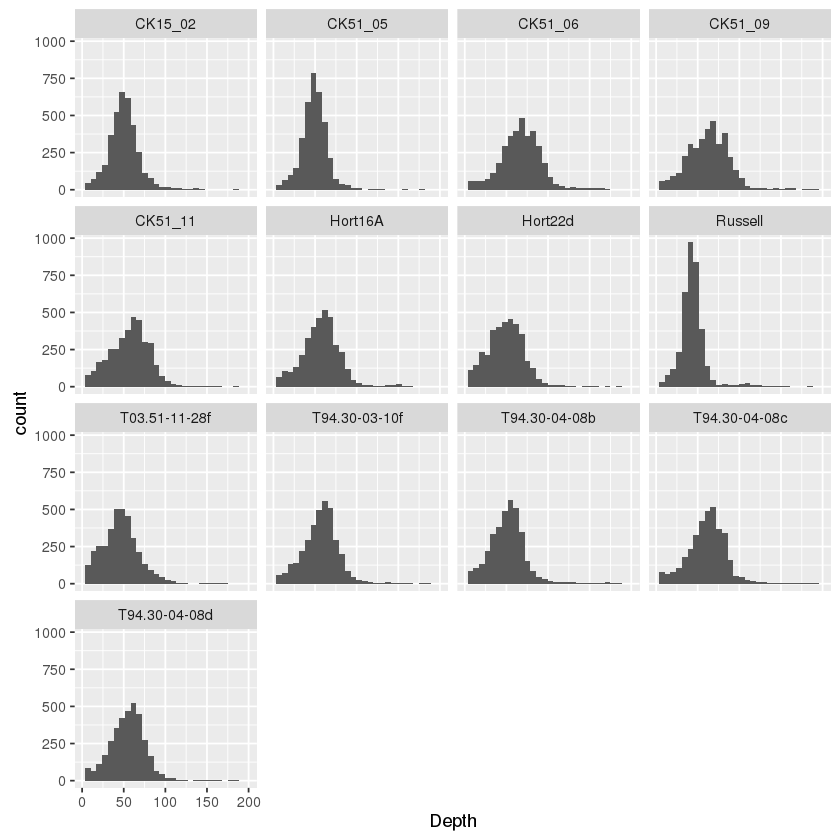

In [23]:
DT2 %>%
    select(-3:-9) %>%
    gather(Vine,Depth,-1:-2) %>%
    ggplot(aes(x=Depth)) + 
    xlim(1,200) +
    geom_histogram() +
    facet_wrap(~ Vine)